In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [54]:
'''
徐家汇：赵若涵2023200231
张江：熊俊沣2023200193
世博：徐国祥2023200190
古美：杨姝钰2023200203
'''

'\n徐家汇：赵若涵2023200231\n张江：熊俊沣2023200193\n世博：徐国祥2023200190\n古美：杨姝钰2023200203\n'

In [5]:
regions_files = {
    '徐家汇': {
        'esf': 'D:/ai finance/hw4_my_data_my_model/data/data_xjh_esf.xlsx',
        'zu': 'D:/ai finance/hw4_my_data_my_model/data/data_xjh_zu.xlsx'
    },
    '张江': {
        'esf': 'D:/ai finance/hw4_my_data_my_model/data/data_zj_esf.xlsx',
        'zu': 'D:/ai finance/hw4_my_data_my_model/data/data_zj_zu.xlsx'
    },
    '世博': {
        'esf': 'D:/ai finance/hw4_my_data_my_model/data/data_sb_esf.xlsx',
        'zu': 'D:/ai finance/hw4_my_data_my_model/data/data_sb_zu.xlsx'
    },
    '古美': {
        'esf': 'D:/ai finance/hw4_my_data_my_model/data/data_gm_esf.xlsx',
        'zu': 'D:/ai finance/hw4_my_data_my_model/data/data_gm_zu.xlsx'
    }
}


raw_data = {}
for region, files in regions_files.items():
    try:
        raw_data[region] = {
            'esf': pd.read_excel(files['esf']),
            'zu': pd.read_excel(files['zu'])
        }
        print(f"成功加载地区: {region}")
        print(f"二手房数据列名: {raw_data[region]['esf'].columns.tolist()}")
        print(f"租房数据列名: {raw_data[region]['zu'].columns.tolist()}\n")
    except FileNotFoundError as e:
        print(f"err: 文件未找到 {e}. ")


成功加载地区: 徐家汇
二手房数据列名: ['Unnamed: 0', 'Title', 'Basic_Info_Raw', 'Community_Name', 'Detail_Address', 'Total_Price', 'Unit_Price', 'House_Labels', 'Metro_Distance']
租房数据列名: ['Unnamed: 0', 'Title', 'Basic_Info_Raw', 'Community_Name', 'Detail_Address', 'Price', 'Price_Unit', 'Metro_Distance', 'Labels']

成功加载地区: 张江
二手房数据列名: ['标题', '户型', '面积(㎡)', '朝向', '建成年份', '经纪人', '小区', '位置', '地铁', '标签', '总价(万元)', '单价(元/㎡)', '楼层']
租房数据列名: ['标题', '租赁方式', '户型', '面积(㎡)', '朝向', '区域', '地铁', '价格(元/月)']

成功加载地区: 世博
二手房数据列名: ['描述', '室数', '厅数', '面积', '层级', '总层数', '朝向', '始建年份', '出售人', '小区名称', '路段', '位置', '房产证登记年份', '特征1', '特征2', '特征3', '特征4', '距离地铁站距离', '总价格', '价格每平方米']
租房数据列名: ['描述', '租赁方式', '室数', '厅数', '面积', '朝向', '一级地址', '二级地址', '三级地址', '距离地铁站距离', '特征1', '特征2', '特征3', '价格']

成功加载地区: 古美
二手房数据列名: ['名称', '价格', '每平方米价格', '户型', '面积', '朝向', '楼层', '建造年代', '小区', '小区地址', '地铁站']
租房数据列名: ['名称', '价格', '出租方式', '户型', '面积', '朝向', '小区', '地铁站']



In [7]:
'''
初步观察:
从上面列名的打印结果可以看出，不同文件的数据结构差异很大。
创建两个标准化的列表，esf_cleaned_list 和 zu_cleaned_list，统一列名和数据格式。

标准列定义:
二手房 (esf): region, community_name, rooms, halls, area_sqm, price_per_sqm, total_price_yuan, year_built, metro_dist_m
租房 (zu): region, community_name, rooms, halls, area_sqm, rent_per_sqm, rent_price_month, metro_dist_m
'''
esf_cleaned_list = []
zu_cleaned_list = []

In [9]:
# 徐家汇数据 
region = '徐家汇'
# 二手房
df_esf = raw_data[region]['esf'].copy()
df_esf['region'] = region
info_raw = df_esf['Basic_Info_Raw'].str.extract(r'(\d+)室(\d+)厅 \| (\d+\.?\d*)㎡ .*? (\d{4})年建')
df_esf[['rooms', 'halls', 'area_sqm', 'year_built']] = info_raw
df_esf.rename(columns={'Community_Name': 'community_name'}, inplace=True)
df_esf['total_price_yuan'] = df_esf['Total_Price'].str.replace('万', '').astype(float) * 10000
df_esf['price_per_sqm'] = df_esf['Unit_Price'].str.replace('元/㎡', '').astype(float)
df_esf['metro_dist_m'] = df_esf['Metro_Distance'].str.extract(r'约(\d+)米').astype(float)
esf_cleaned_list.append(df_esf[['region', 'community_name', 'rooms', 'halls', 'area_sqm', 'price_per_sqm', 'total_price_yuan', 'year_built', 'metro_dist_m']])
# 租房
df_zu = raw_data[region]['zu'].copy()
df_zu['region'] = region
info_raw = df_zu['Basic_Info_Raw'].str.extract(r'(\d+)室(\d+)厅\|(\d+\.?\d*)㎡')
df_zu[['rooms', 'halls', 'area_sqm']] = info_raw
df_zu.rename(columns={'Community_Name': 'region_area','Detail_Address':'community_name', 'Price': 'rent_price_month'}, inplace=True)
df_zu['metro_dist_m'] = df_zu['Metro_Distance'].str.extract(r'约(\d+)米').astype(float)
zu_cleaned_list.append(df_zu[['region', 'community_name', 'rooms', 'halls', 'area_sqm', 'rent_price_month', 'metro_dist_m']])
print("标准化处理完成: 徐家汇")


# 世博数据
region = '世博'
# 二手房
df_esf = raw_data[region]['esf'].copy()
df_esf['region'] = region
df_esf.rename(columns={
    '小区名称': 'community_name', '室数': 'rooms', '厅数': 'halls', 
    '面积': 'area_sqm', '价格每平方米': 'price_per_sqm', 
    '总价格': 'total_price_yuan', '始建年份': 'year_built', 
    '距离地铁站距离': 'metro_dist_m'
}, inplace=True)
esf_cleaned_list.append(df_esf[['region', 'community_name', 'rooms', 'halls', 'area_sqm', 'price_per_sqm', 'total_price_yuan', 'year_built', 'metro_dist_m']])
# 租房
df_zu = raw_data[region]['zu'].copy()
df_zu['region'] = region
df_zu.rename(columns={
    '三级地址': 'community_name', '室数': 'rooms', '厅数': 'halls', 
    '面积': 'area_sqm', '价格': 'rent_price_month', 
    '距离地铁站距离': 'metro_dist_m'
}, inplace=True)
zu_cleaned_list.append(df_zu[['region', 'community_name', 'rooms', 'halls', 'area_sqm', 'rent_price_month', 'metro_dist_m']])
print("标准化处理完成: 世博")


# 张江数据
region = '张江'
# 二手房
df_esf = raw_data[region]['esf'].copy()
df_esf['region'] = region
rooms_halls = df_esf['户型'].str.extract(r'(\d+)室(\d+)厅')
df_esf['rooms'] = rooms_halls[0]
df_esf['halls'] = rooms_halls[1]
df_esf.rename(columns={
    '小区': 'community_name', '面积(㎡)': 'area_sqm', '单价(元/㎡)': 'price_per_sqm', 
    '总价(万元)': 'total_price_yuan', '建成年份': 'year_built'
}, inplace=True)
df_esf['total_price_yuan'] = df_esf['total_price_yuan'] * 10000 # 单位转换
df_esf['metro_dist_m'] = df_esf['地铁'].str.extract(r'约(\d+)米').astype(float)
esf_cleaned_list.append(df_esf[['region', 'community_name', 'rooms', 'halls', 'area_sqm', 'price_per_sqm', 'total_price_yuan', 'year_built', 'metro_dist_m']])
# 租房
df_zu = raw_data[region]['zu'].copy()
df_zu['region'] = region
rooms_halls = df_zu['户型'].str.extract(r'(\d+)室(\d+)厅')
df_zu['rooms'] = rooms_halls[0]
df_zu['halls'] = rooms_halls[1]
df_zu['community_name'] = df_zu['区域'].str.split('-').str[-1]
df_zu.rename(columns={'面积(㎡)': 'area_sqm', '价格(元/月)': 'rent_price_month'}, inplace=True)
df_zu['metro_dist_m'] = df_zu['地铁'].str.extract(r'约(\d+)米').astype(float)
zu_cleaned_list.append(df_zu[['region', 'community_name', 'rooms', 'halls', 'area_sqm', 'rent_price_month', 'metro_dist_m']])
print("标准化处理完成: 张江")

# 古美数据 ---
region = '古美'
# 二手房
df_esf = raw_data[region]['esf'].copy()
df_esf['region'] = region
rooms_halls = df_esf['户型'].str.extract(r'(\d+)室(\d+)厅')
df_esf['rooms'] = rooms_halls[0]
df_esf['halls'] = rooms_halls[1]
df_esf.rename(columns={'小区': 'community_name', '面积': 'area_sqm', '建造年代': 'year_built'}, inplace=True)
df_esf['price_per_sqm'] = df_esf['每平方米价格'].str.replace('元/㎡', '').astype(float)
df_esf['total_price_yuan'] = df_esf['价格'].str.replace('万', '').astype(float) * 10000
df_esf['year_built'] = df_esf['year_built'].str.replace('年建', '')
'''
这里有一个爬虫噪声，面积列有些数据点是belike“卧室7个”，需要处理
'''
df_esf['area_sqm'] = df_esf['area_sqm'].str.replace('㎡', '', regex=False)
df_esf['area_sqm'] = pd.to_numeric(df_esf['area_sqm'], errors='coerce')

df_esf['metro_dist_m'] = df_esf['地铁站'].str.extract(r'约(\d+)米').astype(float)
esf_cleaned_list.append(df_esf[['region', 'community_name', 'rooms', 'halls', 'area_sqm', 'price_per_sqm', 'total_price_yuan', 'year_built', 'metro_dist_m']])
# 租房
df_zu = raw_data[region]['zu'].copy()
df_zu['region'] = region
rooms_halls = df_zu['户型'].str.extract(r'(\d+)室(\d+)厅')
df_zu['rooms'] = rooms_halls[0]
df_zu['halls'] = rooms_halls[1]
df_zu['community_name'] = df_zu['小区'].str.split('-').str[-1]
df_zu['area_sqm'] = df_zu['面积'].str.replace('㎡', '').astype(float)
df_zu['rent_price_month'] = df_zu['价格'].str.replace('元/月', '').astype(float)
df_zu['metro_dist_m'] = df_zu['地铁站'].str.extract(r'约(\d+)米').astype(float)
zu_cleaned_list.append(df_zu[['region', 'community_name', 'rooms', 'halls', 'area_sqm', 'rent_price_month', 'metro_dist_m']])
print("标准化处理完成: 古美")

标准化处理完成: 徐家汇
标准化处理完成: 世博
标准化处理完成: 张江
标准化处理完成: 古美


In [11]:
df_esf_all = pd.concat(esf_cleaned_list, ignore_index=True)
df_zu_all = pd.concat(zu_cleaned_list, ignore_index=True)

numeric_cols_esf = ['rooms', 'halls', 'area_sqm', 'price_per_sqm', 'total_price_yuan', 'year_built', 'metro_dist_m']
numeric_cols_zu = ['rooms', 'halls', 'area_sqm', 'rent_price_month', 'metro_dist_m']

for col in numeric_cols_esf:
    df_esf_all[col] = pd.to_numeric(df_esf_all[col], errors='coerce') # 'coerce'会将无法转换的值变为NaN

for col in numeric_cols_zu:
    df_zu_all[col] = pd.to_numeric(df_zu_all[col], errors='coerce')

# 计算租房数据的 rent_per_sqm ,这个指标在租房数据中需要计算得到
df_zu_all['rent_per_sqm'] = df_zu_all['rent_price_month'] / df_zu_all['area_sqm']


# 最终清洗：删除关键信息缺失或无效的行
df_esf_clean = df_esf_all.dropna(subset=['community_name', 'area_sqm', 'price_per_sqm', 'total_price_yuan']).copy()
df_zu_clean = df_zu_all.dropna(subset=['community_name', 'area_sqm', 'rent_price_month', 'rent_per_sqm']).copy()

# 删除面积或价格为0的无效数据
df_esf_clean = df_esf_clean[df_esf_clean['area_sqm'] > 0]
df_esf_clean = df_esf_clean[df_esf_clean['price_per_sqm'] > 0]
df_zu_clean = df_zu_clean[df_zu_clean['area_sqm'] > 0]
df_zu_clean = df_zu_clean[df_zu_clean['rent_per_sqm'] > 0]


print(f"总计二手房数据: {len(df_esf_clean)} 条")
print("二手房数据预览:")
print(df_esf_clean.head())
print("\n二手房数据信息:")
df_esf_clean.info()

print(f"\n总计租房数据: {len(df_zu_clean)} 条")
print("租房数据预览:")
print(df_zu_clean.head())
print("\n租房数据信息:")
df_zu_clean.info()

总计二手房数据: 4024 条
二手房数据预览:
  region community_name  rooms  halls  area_sqm  price_per_sqm  \
0    徐家汇           海螺花园    3.0    2.0    146.75        88449.0   
1    徐家汇            四季园    3.0    2.0    166.92        94656.0   
2    徐家汇          东方曼哈顿    2.0    2.0     93.83       115101.0   
3    徐家汇          徐家汇花园    2.0    2.0    126.83       100922.0   
4    徐家汇           东安四村    2.0    1.0     47.10       101486.0   

   total_price_yuan  year_built  metro_dist_m  
0        12980000.0      1998.0         726.0  
1        15800000.0      2000.0         463.0  
2        10800000.0      2001.0         490.0  
3        12800000.0      2004.0         763.0  
4         4780000.0      1978.0         552.0  

二手房数据信息:
<class 'pandas.core.frame.DataFrame'>
Index: 4024 entries, 0 to 4107
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   region            4024 non-null   object 
 1   community_name    4024 non-null  

初步探索性数据分析--基于所有有效数据点


各地区二手房每平米售价 (price_per_sqm) 描述统计:
         count          mean           std      min       25%      50%  \
region                                                                   
世博      1200.0  58987.040000  15549.880278  29811.0  46821.50  53734.0   
古美       504.0  71896.569444  20911.861046  32357.0  54457.75  67531.5   
张江      1200.0  64443.458333  33004.038670  14057.0  42033.25  52769.0   
徐家汇     1120.0  89349.368750  18058.055795  38758.0  76746.25  87391.0   

             75%       max  
region                      
世博      69194.75  115606.0  
古美      83636.00  143000.0  
张江      79514.00  481602.0  
徐家汇     99868.00  178663.0  

各地区租房每平米月租金 (rent_per_sqm) 描述统计:
         count        mean        std        min         25%         50%  \
region                                                                     
世博      1200.0  103.410549  23.524285  22.000000   90.000000  101.562500   
古美       582.0   83.191572  24.801580  55.172414   67.391304   74.418605   
张江      

C:\Users\Rh\AppData\Local\Temp\ipykernel_84504\3757555267.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='region', y='price_per_sqm', data=df_esf_clean, palette='viridis', showfliers=False) # showfliers=False 隐藏异常值点，使图形更清晰
C:\Users\Rh\AppData\Local\Temp\ipykernel_84504\3757555267.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='region', y='rent_per_sqm', data=df_zu_clean, palette='viridis', showfliers=False)


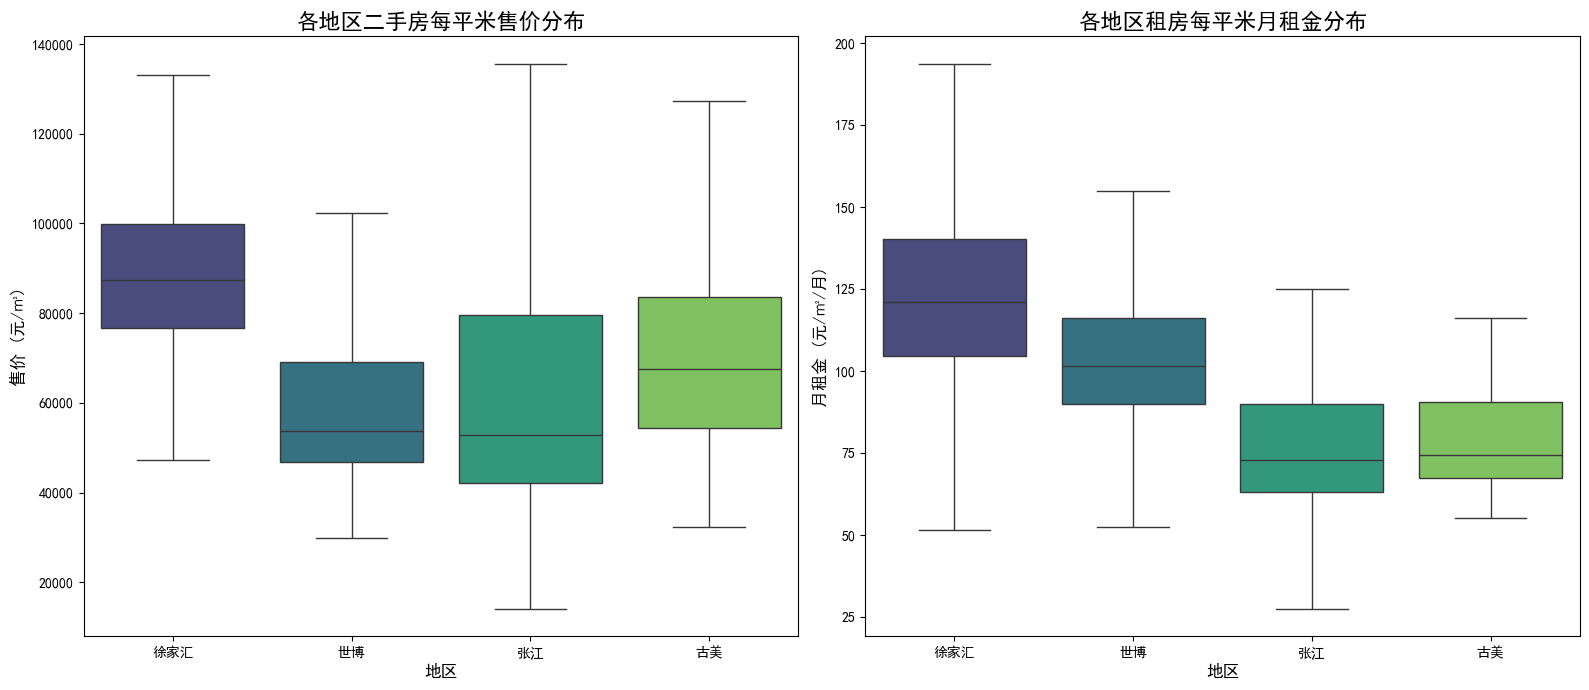

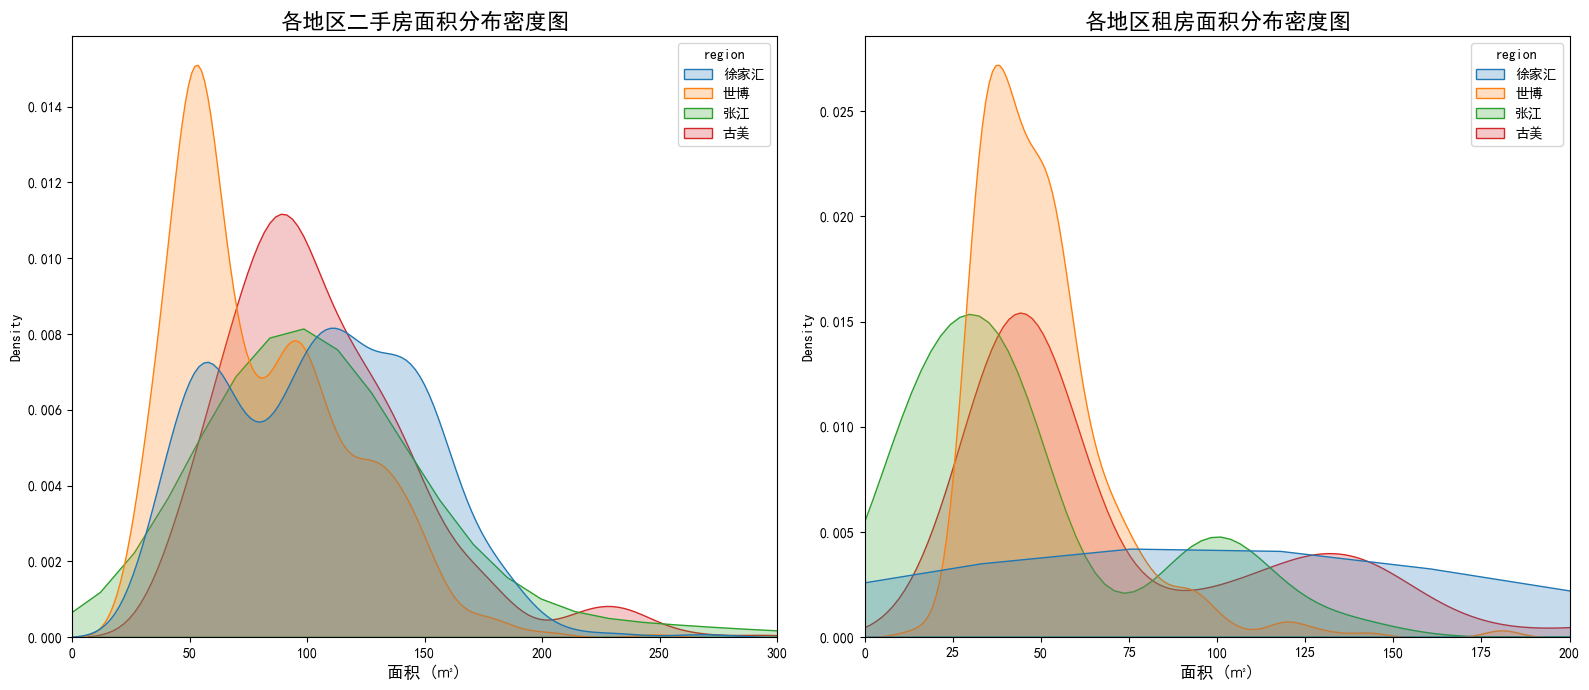

In [14]:
# 核心指标的描述性统计
print("\n各地区二手房每平米售价 (price_per_sqm) 描述统计:")
print(df_esf_clean.groupby('region')['price_per_sqm'].describe())

print("\n各地区租房每平米月租金 (rent_per_sqm) 描述统计:")
print(df_zu_clean.groupby('region')['rent_per_sqm'].describe())


#可视化对比各地区房价与租金
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
sns.boxplot(x='region', y='price_per_sqm', data=df_esf_clean, palette='viridis', showfliers=False) # showfliers=False 隐藏异常值点，使图形更清晰
plt.title('各地区二手房每平米售价分布', fontsize=16)
plt.ylabel('售价 (元/㎡)', fontsize=12)
plt.xlabel('地区', fontsize=12)

plt.subplot(1, 2, 2)
sns.boxplot(x='region', y='rent_per_sqm', data=df_zu_clean, palette='viridis', showfliers=False)
plt.title('各地区租房每平米月租金分布', fontsize=16)
plt.ylabel('月租金 (元/㎡/月)', fontsize=12)
plt.xlabel('地区', fontsize=12)

plt.tight_layout()
plt.show()

# 可视化对比各地区房屋面积 
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
sns.kdeplot(data=df_esf_clean, x='area_sqm', hue='region', common_norm=False, fill=True)
plt.title('各地区二手房面积分布密度图', fontsize=16)
plt.xlabel('面积 (㎡)', fontsize=12)
plt.xlim(0, 300) # 限制x轴范围，以便观察主要分布

plt.subplot(1, 2, 2)
sns.kdeplot(data=df_zu_clean, x='area_sqm', hue='region', common_norm=False, fill=True)
plt.title('各地区租房面积分布密度图', fontsize=16)
plt.xlabel('面积 (㎡)', fontsize=12)
plt.xlim(0, 200)

plt.tight_layout()
plt.show()

In [16]:
df_zu_all.to_excel("D:/ai finance/hw4_my_data_my_model/data/data_zu_all.xlsx")
df_esf_all.to_excel("D:/ai finance/hw4_my_data_my_model/data/data_esf_all.xlsx")

In [17]:
df_zu_clean.to_excel("D:/ai finance/hw4_my_data_my_model/data/data_zu_clean.xlsx")
df_esf_clean.to_excel("D:/ai finance/hw4_my_data_my_model/data/data_esf_clean.xlsx")

In [20]:
# 按小区聚合数据
# 计算每个小区的每平米售价中位数和房源数量
esf_agg = df_esf_clean.groupby(['region', 'community_name']).agg(
    median_price_sqm=('price_per_sqm', 'median'),
    esf_count=('community_name', 'count')
).reset_index()

# 计算每个小区的每平米租金中位数和房源数量
zu_agg = df_zu_clean.groupby(['region', 'community_name']).agg(
    median_rent_sqm=('rent_per_sqm', 'median'),
    zu_count=('community_name', 'count')
).reset_index()

df_merged = pd.merge(esf_agg, zu_agg, on=['region', 'community_name'], how='inner')

# 过滤掉样本量过少的小区
#df_merged_filtered = df_merged[(df_merged['esf_count'] >= 2) & (df_merged['zu_count'] >= 2)].copy()

print(f" {len(df_merged)} 个小区同时拥有二手房和租房数据用于后续分析。")
print("聚合后的数据预览:")
print(df_merged.head())

 255 个小区同时拥有二手房和租房数据用于后续分析。
聚合后的数据预览:
  region community_name  median_price_sqm  esf_count  median_rent_sqm  \
0     世博         万科金色城品           89563.0          3       144.444444   
1     世博           上南一村           52224.0         24       119.791271   
2     世博           上南七村           46635.0         10       121.621622   
3     世博           上南三村           51261.0         20       122.799550   
4     世博           上南九村           52127.0         71        96.782597   

   zu_count  
0         4  
1        34  
2        20  
3        14  
4        46  


In [41]:
#租售比
df_merged['price_to_rent_ratio_direct'] = df_merged['median_price_sqm'] / (df_merged['median_rent_sqm'] )
#地铁距离
df_zu_unique = (
    df_zu_clean
    .sort_values('metro_dist_m', ascending=True)  
    .drop_duplicates(subset=['region', 'community_name'], keep='first')
)
df_merged = pd.merge(
    df_merged,
    df_zu_unique[['region', 'community_name', 'metro_dist_m']], 
    on=['region', 'community_name'], 
    how='left'
)

In [43]:
df_merged.head()

,region,community_name,median_price_sqm,esf_count,median_rent_sqm,zu_count,price_to_rent_ratio_direct,metro_dist_m_x,metro_dist_m_y
0,世博,万科金色城品,89563.0,3,144.444444,4,620.051538,459.0,459.0
1,世博,上南一村,52224.0,24,119.791271,34,435.958308,224.0,224.0
2,世博,上南七村,46635.0,10,121.621622,20,383.443333,782.0,782.0
3,世博,上南三村,51261.0,20,122.799550,14,417.436385,432.0,432.0
4,世博,上南九村,52127.0,71,96.782597,46,538.598898,286.0,286.0


In [45]:
df_merged.to_excel("D:/ai finance/hw4_my_data_my_model/data/data_merged.xlsx")

探索性数据分析2：基于merged小区数据

C:\Users\Rh\AppData\Local\Temp\ipykernel_84504\526063756.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='region', y='price_per_sqm', data=df_esf_clean, palette='Set2')
C:\Users\Rh\AppData\Local\Temp\ipykernel_84504\526063756.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='region', y='rent_per_sqm', data=df_zu_clean, palette='Set2')


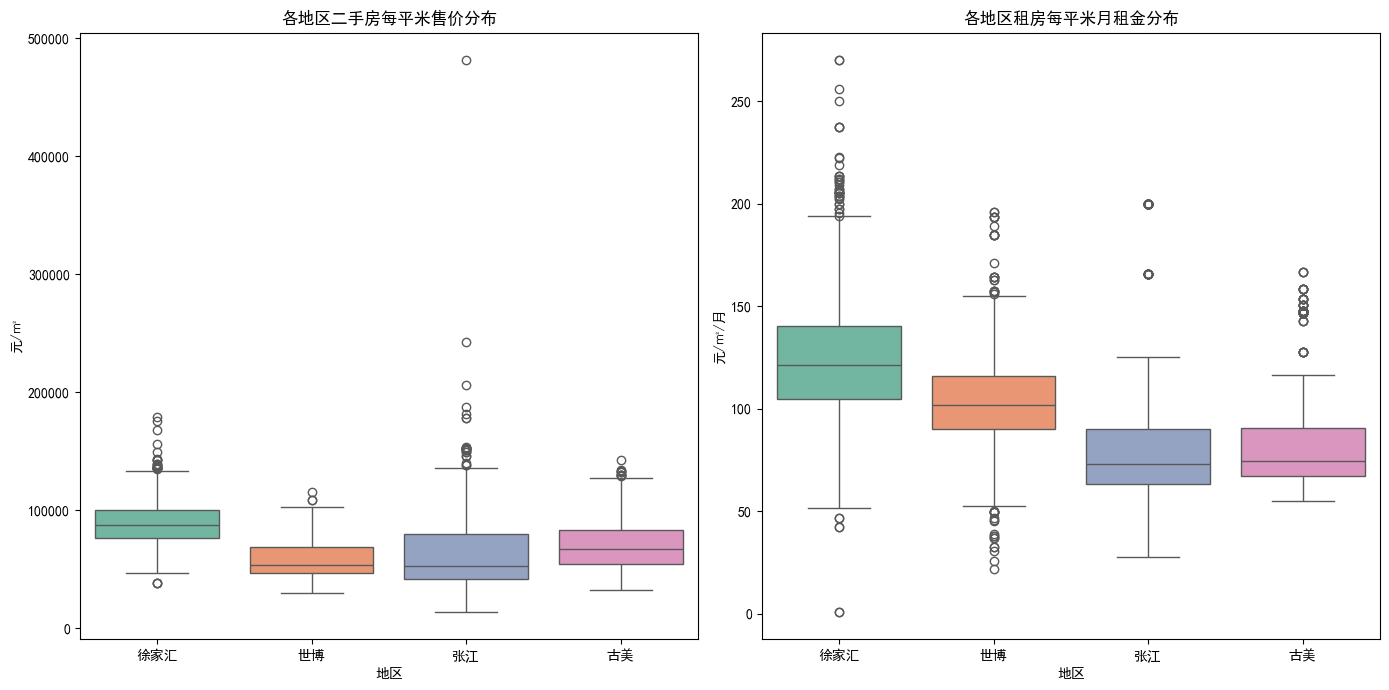

In [48]:
# 描述性统计与异常值检测 (按地区对比)
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.boxplot(x='region', y='price_per_sqm', data=df_esf_clean, palette='Set2')
plt.title('各地区二手房每平米售价分布')
plt.ylabel('元/㎡')
plt.xlabel('地区')

plt.subplot(1, 2, 2)
sns.boxplot(x='region', y='rent_per_sqm', data=df_zu_clean, palette='Set2')
plt.title('各地区租房每平米月租金分布')
plt.ylabel('元/㎡/月')
plt.xlabel('地区')
plt.tight_layout()
plt.show()

C:\Users\Rh\AppData\Local\Temp\ipykernel_84504\224996496.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='price_to_rent_ratio_direct', y='region', data=region_ratio, palette='viridis')


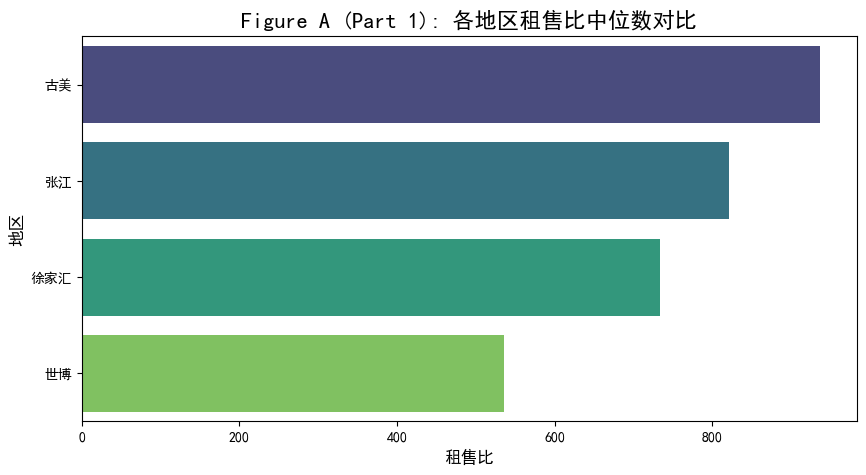

C:\Users\Rh\AppData\Local\Temp\ipykernel_84504\224996496.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='price_to_rent_ratio_direct', y=y_labels_a, data=df_plot_a, palette='viridis')


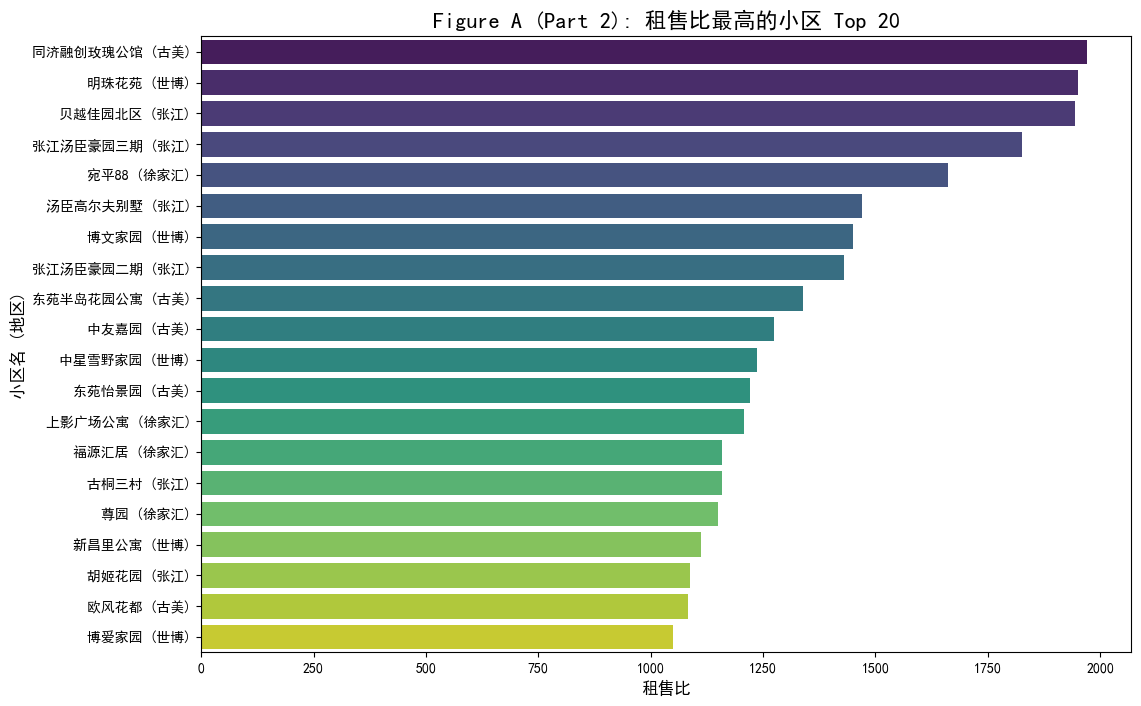

In [56]:
# Figure A: 绘制租售比条形图 (分两部分) ---
# Part 1: 按地区看平均租售比
region_ratio = df_merged.groupby('region')['price_to_rent_ratio_direct'].median().reset_index().sort_values('price_to_rent_ratio_direct', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='price_to_rent_ratio_direct', y='region', data=region_ratio, palette='viridis')
plt.title('Figure A (Part 1): 各地区租售比中位数对比', fontsize=16)
plt.xlabel('租售比', fontsize=12)
plt.ylabel('地区', fontsize=12)
plt.show()

# Part 2: 看具体小区的租售比 Top 20
df_plot_a = df_merged.sort_values('price_to_rent_ratio_direct', ascending=False).head(20)

plt.figure(figsize=(12, 8))
# 在Y轴标签上加入地区信息
y_labels_a = df_plot_a['community_name'] + " (" + df_plot_a['region'] + ")"
sns.barplot(x='price_to_rent_ratio_direct', y=y_labels_a, data=df_plot_a, palette='viridis')
plt.title('Figure A (Part 2): 租售比最高的小区 Top 20', fontsize=16)
plt.xlabel('租售比', fontsize=12)
plt.ylabel('小区名 (地区)', fontsize=12)
plt.show()

C:\Users\Rh\AppData\Local\Temp\ipykernel_84504\1019417372.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='region', y='price_to_rent_ratio_direct', data=df_merged, palette='Set2')


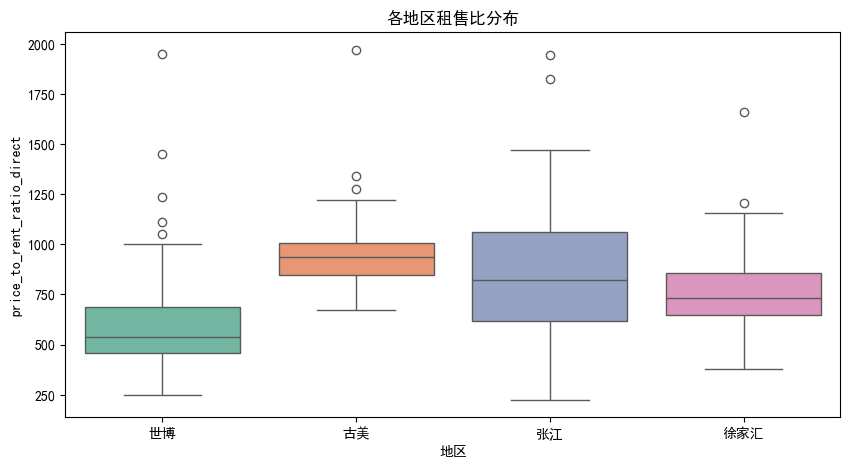

In [52]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='region', y='price_to_rent_ratio_direct', data=df_merged, palette='Set2')
plt.title('各地区租售比分布')
plt.ylabel('price_to_rent_ratio_direct')
plt.xlabel('地区')
plt.show()